# Imports

## Import required packages

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt

from tcn import TCN
from keras_nlp.layers import TransformerEncoder
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Concatenate, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.saving import save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils.class_weight import compute_class_weight

c:\Users\ASUS\Documents\Radar\Code\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Point Cloud (8 features, bootstrap with noise)

## Data Preprocessing

### Full preprocessing (No visual)

In [2]:
dataset_path = './dataset22/Radar 1 (1m)'
classes = ["Berdiri", "Duduk", "Jalan", "Jatuh"]

timesteps = 30
eps_value = 0.3
TARGET_POINTS = 128
MIN_POINTS = 10

labels = []
data = []

plt.rcParams["figure.figsize"] = (10, 8)

def extract_features(df):
    return df[["x","y","z","doppler","SNR","Range","Azimuth","Elevation"]].to_numpy()

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)

    for subject_folder in os.listdir(class_path):
        subject_path = os.path.join(class_path, subject_folder)

        if not os.path.isdir(subject_path):
            continue

        for file_name in os.listdir(subject_path):

            file_path = os.path.join(subject_path, file_name)
            df = pd.read_csv(file_path)

            grouped = df.groupby("frame_id")

            # reset per-file
            processed_frames = []

            # ---- FIRST PASS: DBSCAN for each frame ----
            dbscan_results = {}

            for frame_id, frame_points in grouped:
                if len(frame_points) < MIN_POINTS:
                    continue

                xyz = frame_points[["x", "y", "z"]].to_numpy()
                db = DBSCAN(eps=eps_value, min_samples=3).fit(xyz)
                labels_db = db.labels_

                dbscan_results[frame_id] = labels_db

            if len(dbscan_results) == 0:
                continue

            # re-run grouping because grouped is exhausted
            grouped = df.groupby("frame_id")

            # ---- SECOND PASS: extract cluster + bootstrap ----
            for frame_id, frame_points in grouped:

                if frame_id not in dbscan_results:
                    continue

                labels_db = dbscan_results[frame_id]

                # largest cluster
                unique = [c for c in set(labels_db) if c != -1]
                if len(unique) == 0:
                    continue

                largest = max(unique, key=lambda c: np.sum(labels_db == c))
                mask = (labels_db == largest)

                cluster_points = frame_points.iloc[mask]

                # BOOTSTRAP
                if len(cluster_points) < TARGET_POINTS:
                    cluster_points = cluster_points.sample(TARGET_POINTS, replace=True)
                elif len(cluster_points) > TARGET_POINTS:
                    cluster_points = cluster_points.sample(TARGET_POINTS, replace=False)

                numeric_cols = ["x", "y", "z", "doppler", "SNR", "Range", "Azimuth", "Elevation"]
                sigma = 0.01
                noise = np.random.normal(0, sigma, cluster_points[numeric_cols].shape)
                cluster_points.loc[:, numeric_cols] = cluster_points[numeric_cols] + noise

                # get 8 features
                feat = extract_features(cluster_points)
                processed_frames.append(feat)

            # ---- SLIDING WINDOW ----
            if len(processed_frames) >= timesteps:
              for i in range(len(processed_frames) - timesteps + 1):

                  window = np.array(processed_frames[i:i+timesteps])  # (30, 50, 8)
                  data.append(window)

                  label = 1 if class_name.lower() == "jatuh" else 0
                  labels.append(label)

### Normalize and split data

In [3]:
data = np.array(data)         
labels = np.array(labels)          

labels = to_categorical(labels, num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, shuffle=True
)

scaler = StandardScaler()

X_train_rs = X_train.reshape(-1, X_train.shape[-1])
X_test_rs  = X_test.reshape(-1, X_test.shape[-1])

X_train_scaled = scaler.fit_transform(X_train_rs).reshape(X_train.shape)
X_test_scaled  = scaler.transform(X_test_rs).reshape(X_test.shape)

y_train_labels = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train_labels
)

class_weights = {
    0: class_weights[0],
    1: class_weights[1]
}

print("Class weights:", class_weights)

joblib.dump(scaler, "./v3/v3_Scaler.pkl")

Class weights: {0: 0.6084973595775324, 1: 2.8042035398230087}


['./v3/v3_Scaler.pkl']

In [4]:
print(len(data))
print(len(labels))
print(data.shape)
print(labels.shape)

print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)

6338
6338
(6338, 30, 128, 8)
(6338, 2)
(5070, 30, 128, 8)
(5070, 2)
(1268, 30, 128, 8)
(1268, 2)


## Model Architecture for Point Cloud

### Helper classes

In [5]:
class PointFeatureEncoder(layers.Layer):
    def build(self, input_shape):
        # input: (batch, T, P, F)
        self.T = input_shape[1]
        self.P = input_shape[2]
        self.F = input_shape[3]
        self.output_dim = self.P * self.F

    def call(self, x):
        # reshape using static known size
        x = tf.reshape(x, (-1, self.T, self.output_dim))
        return x

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.T, self.output_dim)

class ExponentialSmoothing(tf.keras.layers.Layer):
    def __init__(self, alpha=0.1, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha

    def call(self, inputs):
        # inputs shape: (B, T, H, W)
        x = inputs

        B = tf.shape(x)[0]
        T = tf.shape(x)[1]
        H = tf.shape(x)[2]
        W = tf.shape(x)[3]

        ta = tf.TensorArray(dtype=x.dtype, size=T)

        # --- initial timestep ---
        prev = x[:, 0, :, :]
        ta = ta.write(0, prev)

        # --- smoothing loop ---
        def body(t, prev, ta):
            current = x[:, t, :, :]                       # (B, H, W)
            smoothed = self.alpha * current + (1 - self.alpha) * prev
            ta = ta.write(t, smoothed)
            return t + 1, smoothed, ta

        def cond(t, prev, ta):
            return t < T

        _, _, ta = tf.while_loop(cond, body, loop_vars=[1, prev, ta])

        # Stack back: (T, B, H, W)
        out = ta.stack()

        # Transpose to (B, T, H, W)
        out = tf.transpose(out, [1, 0, 2, 3])

        return out

    def compute_output_shape(self, input_shape):
        return input_shape

# ---- Positional Encoding ----
class PositionalEncoding(layers.Layer):
    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        d_model = tf.shape(inputs)[-1]

        position = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(
            tf.range(0, d_model, 2, dtype=tf.float32)
            * -(tf.math.log(10000.0) / tf.cast(d_model, tf.float32))
        )

        angle_rads = position * div_term
        pos_encoding = tf.concat([tf.sin(angle_rads), tf.cos(angle_rads)], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return inputs + pos_encoding

### Model definition

In [6]:
def ttsnet():
    timesteps = 30
    points = 128
    features = 8

    # {'mhsa_num_heads': 2, 'mhsa_key_dim': 32, 'mhsa_dense': 128, 'lr': 0.001}
    # {'tcn_filters': 128, 'tcn_kernel_size': 5, 'tcn_dilation_set': 'A', 'tcn_dense': 96, 'lr': 0.001}
    # {'tr_heads': 2, 'tr_dim': 32, 'tr_dropout': 0.0, 'tr_dense': 128, 'lr': 0.001}
    # {'fusion_dropout': 0.5, 'fc1_units': 160, 'fc2_units': 96, 'activation': 'relu', 'lr': 0.00040951724636134065}

    mhsa_num_heads  = 2
    mhsa_key_dim    = 32
    mhsa_dense      = 128

    tcn_filters     = 128
    kernel_size     = 5
    dil_1           = [1, 2, 4]
    tcn_dense       = 96

    tr_heads        = 2
    tr_dim          = 32
    tr_dropout      = 0.0
    tr_dense        = 128

    fusion_dropout  = 0.5
    fc1_units       = 160
    fc2_units       = 96
    act             = "relu"
    lr              = 0.00040951724636134065

    inputs = Input(shape=(timesteps, points, features))
    encoded = PointFeatureEncoder()(inputs)

    # ===== Branch A: MHSA =====
    mhsa = MultiHeadAttention(num_heads=mhsa_num_heads, key_dim=mhsa_key_dim)(encoded, encoded)
    mhsa_out = Dense(mhsa_dense, activation="linear")(mhsa)

    # ===== Branch B: TCN =====
    tcn_1 = TCN(nb_filters=tcn_filters, kernel_size=kernel_size,
                dilations=dil_1, activation="relu", return_sequences=True)(encoded)

    tcn_out = Dense(tcn_dense, activation="linear")(tcn_1)

    # ===== Branch C: Transformer =====
    pos = PositionalEncoding()(encoded)

    tr_1 = TransformerEncoder(
        num_heads=tr_heads, intermediate_dim=tr_dim, dropout=tr_dropout
    )(pos)

    transformer_out = Dense(tr_dense, activation="linear")(tr_1)

    fused = Concatenate()([mhsa_out, transformer_out, tcn_out])
    fused = GlobalAveragePooling1D()(fused)
    fused = Dropout(fusion_dropout)(fused)

    fc = Dense(fc1_units, activation=act)(fused)
    fc = Dense(fc2_units, activation=act)(fc)

    output = Dense(2, activation="softmax")(fc)

    model = Model(inputs, output)

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [7]:
model = ttsnet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 128,   │          0 │ -                 │
│ (InputLayer)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ point_feature_enco… │ (None, 30, 1024)  │          0 │ input_layer[0][0] │
│ (PointFeatureEncod… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 30, 1024)  │          0 │ point_feature_en… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1024)  │    263,360 │ point_feature_en… │
│ (MultiHeadAttentio… │                   │            │ point_feature_en… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, 30, 1024)  │  4,269,088 │ positional_encod… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tcn (TCN)           │ (None, 30, 128)   │  1,196,928 │ point_feature_en… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 128)   │    131,200 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 30, 128)   │    131,200 │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30, 96)    │     12,384 │ tcn[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 30, 352)   │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_2[0][0],    │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 352)       │          0 │ concatenate[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 352)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 160)       │     56,480 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 96)        │     15,456 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │        194 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,076,290 (23.18 MB)

 Trainable params: 6,076,290 (23.18 MB)

 Non-trainable params: 0 (0.00 B)

### Model training

In [8]:
model = ttsnet()
history = model.fit(
    X_train_scaled, y_train,
    epochs=40,
    validation_data=(X_test_scaled, y_test),
    batch_size=32,
    class_weight=class_weights
)

Epoch 1/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 117s 659ms/step - accuracy: 0.7275 - loss: 0.7203 - val_accuracy: 0.9101 - val_loss: 0.2113
Epoch 2/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 106s 670ms/step - accuracy: 0.9112 - loss: 0.2384 - val_accuracy: 0.8793 - val_loss: 0.2485
Epoch 3/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 88s 555ms/step - accuracy: 0.9334 - loss: 0.1745 - val_accuracy: 0.9409 - val_loss: 0.1298
Epoch 4/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 122s 770ms/step - accuracy: 0.9262 - loss: 0.2155 - val_accuracy: 0.9653 - val_loss: 0.1252
Epoch 5/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 91s 571ms/step - accuracy: 0.9707 - loss: 0.0899 - val_accuracy: 0.9732 - val_loss: 0.0757
Epoch 6/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 89s 560ms/step - accuracy: 0.9743 - loss: 0.0767 - val_accuracy: 0.9819 - val_loss: 0.0516
Epoch 7/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 89s 557ms/step - accuracy: 0.9730 - loss: 0.0836 - val_accuracy: 0.9890 - val_loss: 0.0610
Epoch 8/40
159/159 ━━━━━━━━━━━━━━━━━━━━ 88s 552ms/step - accuracy: 0.9843 - loss

In [9]:
save_model(model, "./v3/v3_Model.keras")

### Model evaluation

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 6.2973e-05

✅ Final Test Loss: 0.0001
✅ Final Test Accuracy: 100.00%


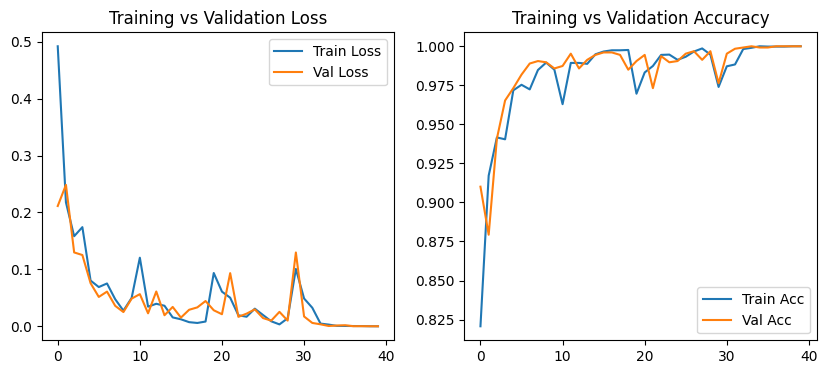

In [10]:
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\n✅ Final Test Loss: {test_loss:.4f}")
print(f"✅ Final Test Accuracy: {test_accuracy * 100:.2f}%")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step
Confusion Matrix:
[[1031    0]
 [   0  237]]

Evaluation Metrics:
Accuracy : 100.00%
Precision: 100.00%
Recall   : 100.00%
F1-Score : 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1031
           1       1.00      1.00      1.00       237

    accuracy                           1.00      1268
   macro avg       1.00      1.00      1.00      1268
weighted avg       1.00      1.00      1.00      1268



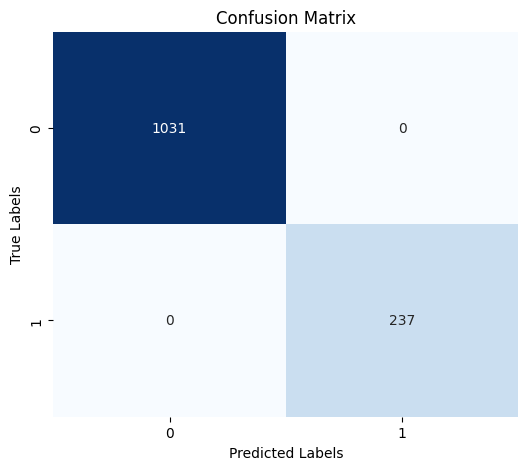

In [11]:
y_pred = model.predict(X_test_scaled)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Hitung metrik evaluasi
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')

# Cetak hasil evaluasi
print("\nEvaluation Metrics:")
print(f"Accuracy : {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall   : {recall*100:.2f}%")
print(f"F1-Score : {f1*100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Validation data

In [12]:
testing_dir = "./testing22"
class_names = ["Normal", "Jatuh"]
results = []

for class_name in os.listdir(testing_dir):
    class_path = os.path.join(testing_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        print(f"\nProcessing: {file_path}")

        df = pd.read_csv(file_path)
        grouped = df.groupby("frame_id")

        processed_frames = []
        dbscan_results = {}

        for frame_id, frame_points in grouped:
            if len(frame_points) < MIN_POINTS:
                continue

            xyz = frame_points[["x", "y", "z"]].to_numpy()
            db = DBSCAN(eps=eps_value, min_samples=3).fit(xyz)
            labels_db = db.labels_

            dbscan_results[frame_id] = labels_db

        if len(dbscan_results) == 0:
            print("  ❌ No usable frames")
            results.append({
                "file": file_name,
                "true_class": class_name,
                "predicted_class": "NO FRAMES"
            })
            continue

        # Regroup (generator exhausted)
        grouped = df.groupby("frame_id")

        # -----------------------------------------------
        # 2nd PASS – Extract largest cluster & bootstrap
        # -----------------------------------------------
        for frame_id, frame_points in grouped:
            if frame_id not in dbscan_results:
                continue

            labels_db = dbscan_results[frame_id]
            clusters = [c for c in set(labels_db) if c != -1]

            if len(clusters) == 0:
                continue

            largest = max(clusters, key=lambda c: np.sum(labels_db == c))
            mask = (labels_db == largest)

            cluster_points = frame_points.iloc[mask]

            # Bootstrap to 50 points
            if len(cluster_points) < TARGET_POINTS:
                cluster_points = cluster_points.sample(TARGET_POINTS, replace=True)
            else:
                cluster_points = cluster_points.sample(TARGET_POINTS, replace=False)

            numeric_cols = ["x", "y", "z", "doppler", "SNR", "Range", "Azimuth", "Elevation"]
            sigma = 0.01
            noise = np.random.normal(0, sigma, cluster_points[numeric_cols].shape)
            cluster_points.loc[:, numeric_cols] = cluster_points[numeric_cols] + noise

            # Extract 8 features
            feat = cluster_points[
                ["x","y","z","doppler","SNR", "Range", "Azimuth", "Elevation"]
            ].to_numpy()

            processed_frames.append(feat)

        # -----------------------------------------------
        # Sliding window (30 frames)
        # -----------------------------------------------
        windows = []
        if len(processed_frames) >= timesteps:
            for i in range(len(processed_frames) - timesteps + 1):
                windows.append(np.array(processed_frames[i:i+timesteps]))  # (30,50,8)
        else:
            print("  ❌ Not enough frames for sliding window")
            results.append({
                "file": file_name,
                "true_class": class_name,
                "predicted_class": "TOO SHORT"
            })
            continue

        windows = np.array(windows)   # (N,30,50,8)
        print(f"  ✓ Windows: {windows.shape}")

        # -----------------------------------------------
        # SCALE
        # -----------------------------------------------
        windows_rs = windows.reshape(-1, windows.shape[-1])
        windows_scaled = scaler.transform(windows_rs).reshape(windows.shape)

        print(f"  → Final input shape: {windows_scaled.shape}")

        # -----------------------------------------------
        # Predict
        # -----------------------------------------------
        predictions = model.predict(windows_scaled)
        window_classes = np.argmax(predictions, axis=1)

        final_class = np.bincount(window_classes).argmax()
        print(f"  → Predicted: {class_names[final_class]}")

        results.append({
            "file": file_name,
            "true_class": class_name,
            "predicted_class": class_names[final_class]
        })

# ============================================================
# 4. SHOW RESULTS
# ============================================================
print("\n\n================ FINAL RESULTS ================")
for r in results:
    print(f"{r['file']} → TRUE={r['true_class']} | PRED={r['predicted_class']}")


Processing: ./testing22\Berdiri\berdiri1.csv
  ✓ Windows: (23, 30, 128, 8)
  → Final input shape: (23, 30, 128, 8)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
  → Predicted: Normal

Processing: ./testing22\Berdiri\berdiri2.csv
  ✓ Windows: (23, 30, 128, 8)
  → Final input shape: (23, 30, 128, 8)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
  → Predicted: Normal

Processing: ./testing22\Berdiri\berdiri3.csv
  ✓ Windows: (18, 30, 128, 8)
  → Final input shape: (18, 30, 128, 8)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
  → Predicted: Normal

Processing: ./testing22\Duduk\duduk1.csv
  ✓ Windows: (10, 30, 128, 8)
  → Final input shape: (10, 30, 128, 8)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
  → Predicted: Normal

Processing: ./testing22\Duduk\duduk2.csv
  ✓ Windows: (6, 30, 128, 8)
  → Final input shape: (6, 30, 128, 8)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
  → Predicted: Normal

Processing: ./testing22\Duduk\duduk3.csv
  ✓ Windows: (6, 30, 128, 8)
  → Final input shape: (6, 30, 128, 8)
1/1 ━━━━━━━━━━━━━